In [53]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [54]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical

Initial Learning Rate<br> 
Number of Epochs<br>
Batch Size<br>

In [55]:
INIT_LR = 0.0001
EPOCHS = 10
BS = 128

In [56]:
DATA = r"dataset"
CATEGORIES = ["with_mask", "without_mask"]

Loading Images

In [57]:
data = []
labels = []

In [58]:
for category in CATEGORIES:
    path = os.path.join(DATA, category)
    for img in os.listdir(path):
    	img_path = os.path.join(path, img)
    	image = load_img(img_path, target_size=(224, 224))
    	image = img_to_array(image)
    	image = preprocess_input(image)

    	data.append(image)
    	labels.append(category)

C:\Users\laksh\AppData\Roaming\Python\Python39\site-packages\PIL\Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Performing One - Hot Encoding On the Labels

In [59]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [60]:
data = np.array(data, dtype = "float32")
labels = np.array(labels)

Splitting Images into Training and Testing sets

In [61]:
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size = 0.20, stratify = labels, random_state = 42)

Data Augmentation for validation set


In [62]:

aug = ImageDataGenerator(
	rotation_range = 20,
	zoom_range = 0.15,
	width_shift_range = 0.2,
	height_shift_range = 0.2,
	shear_range = 0.15,
	horizontal_flip = True,
	fill_mode = "nearest")

Loading the MobileNetV2 network<br>
Head Fully Connected layer is dropped

In [63]:
baseModel = MobileNetV2(weights = "imagenet", include_top = False, input_tensor = Input(shape = (224, 224, 3)))


Head of the model that will be placed on top of the base model

In [64]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size = (7, 7))(headModel)
headModel = Flatten(name = "flatten")(headModel)
headModel = Dense(128, activation = "relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation = "softmax")(headModel)


Place the head Fully Connected model on top of the base model (this will become the actual model that will be trained)

In [65]:
model = Model(inputs = baseModel.input, outputs = headModel)

Iterate over all layers in the base model and freeze them so they are not updated during the first training process

In [66]:
for layer in baseModel.layers:
	layer.trainable = False

Compiling the Model

In [67]:
opt = Adam(lr = INIT_LR, decay = INIT_LR/EPOCHS)
model.compile(loss = "binary_crossentropy", optimizer = opt, metrics = ["accuracy"])

c:\Users\laksh\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [68]:
H = model.fit(aug.flow(trainX, trainY, batch_size = BS), steps_per_epoch = len(trainX)//BS, validation_data = (testX, testY), validation_steps = len(testX)//BS, epochs = EPOCHS)

Epoch 1/10
33/33 [==============================] - 73s 2s/step - loss: 0.5919 - accuracy: 0.7250 - val_loss: 0.3021 - val_accuracy: 0.9588
Epoch 2/10
33/33 [==============================] - 73s 2s/step - loss: 0.2670 - accuracy: 0.9411 - val_loss: 0.1562 - val_accuracy: 0.9747
Epoch 3/10
33/33 [==============================] - 75s 2s/step - loss: 0.1656 - accuracy: 0.9604 - val_loss: 0.1065 - val_accuracy: 0.9757
Epoch 4/10
33/33 [==============================] - 73s 2s/step - loss: 0.1297 - accuracy: 0.9667 - val_loss: 0.0836 - val_accuracy: 0.9775
Epoch 5/10
33/33 [==============================] - 71s 2s/step - loss: 0.1010 - accuracy: 0.9732 - val_loss: 0.0701 - val_accuracy: 0.9813
Epoch 6/10
33/33 [==============================] - 76s 2s/step - loss: 0.0852 - accuracy: 0.9790 - val_loss: 0.0633 - val_accuracy: 0.9841
Epoch 7/10
33/33 [==============================] - 73s 2s/step - loss: 0.0757 - accuracy: 0.9821 - val_loss: 0.0555 - val_accuracy: 0.9832
Epoch 8/10
33/33 [==

Evaluating the Network by testing it

In [69]:
predIdxs = model.predict(testX, batch_size = BS)

For each image in the testing set, the index of the label with corresponding largest predicted probability needs to be found

In [70]:
predIdxs = np.argmax(predIdxs, axis = 1)

Classification Report

In [71]:
print(classification_report(testY.argmax(axis = 1), predIdxs, target_names = lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.98      0.99      0.98       534
without_mask       0.99      0.98      0.98       535

    accuracy                           0.98      1069
   macro avg       0.98      0.98      0.98      1069
weighted avg       0.98      0.98      0.98      1069



Saving the Model

In [72]:
model.save("mask_detector.model", save_format = "h5")

Training Loss and Accuracy

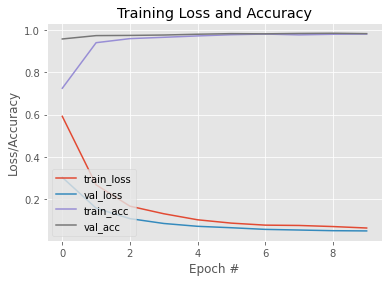

In [73]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label = "train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label = "val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label = "train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label = "val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc = "lower left")
plt.savefig("plot.png")